In [1]:
import lzma
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from neural_network import NeuralNetwork

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
import glob

RECORD_COUNT = len(glob.glob("../record_*")) 

# Load and preprocess your collected data


In [4]:
from statistics import mean

snapshots = []

for i in range(RECORD_COUNT):
    try:
        with lzma.open(f"../record_{i}.npz", "rb") as file:
            data = pickle.load(file)
            avg_speed = mean([d.car_speed for d in data])
            print(f"record_{i} average speed: {avg_speed}")
            if avg_speed <= 30:
                snapshots = snapshots + data
    except FileNotFoundError:
        print(f"Skipping record_{i}.npz - file not found")
    except Exception as e:
        print(f"Error processing record_{i}.npz: {e}")
        continue

package_folder: /home/nathan/projects/RallyRobotPilot_2025/.venv/lib/python3.13/site-packages/ursina
asset_folder: /home/nathan/projects/RallyRobotPilot_2025/.venv/lib/python3.13/site-packages


which: no blender in (/home/nathan/projects/RallyRobotPilot_2025/.venv/bin:/home/nathan/.rvm/gems/ruby-3.3.8/bin:/home/nathan/.rvm/gems/ruby-3.3.8@global/bin:/home/nathan/.rvm/rubies/ruby-3.3.8/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/sbin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/home/nathan/.rvm/bin)


record_0 average speed: 37.4117920554004
record_1 average speed: 40.77769929909509
record_2 average speed: 41.30762935273441
record_3 average speed: 40.1125858757231
record_4 average speed: 38.769415028717205
Skipping record_5.npz - file not found
Skipping record_6.npz - file not found
Skipping record_7.npz - file not found
Skipping record_8.npz - file not found
Skipping record_9.npz - file not found
record_10 average speed: 39.59026164436772
Skipping record_11.npz - file not found
record_12 average speed: 21.02368163925553
record_13 average speed: 27.55777011326381


In [5]:
X_scalar_list = [
    [s.car_speed, *s.raycast_distances]
    for s in snapshots
]

# 2. Create the list of labels (y). The original list comprehension was a bit complex.
y_list = [s.current_controls for s in snapshots]

# 3. Convert all lists to NumPy arrays with a specific data type
features = np.array(X_scalar_list, dtype=np.float32)
labels = np.array(y_list, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define your neural network model


In [6]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
    (5): Sigmoid()
  )
)

# Set up training loop with loss function and optimizer

In [7]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)

# Train the model and save checkpoints


In [8]:
from torch.utils.data import Dataset

class Data(Dataset):
    def __init__(self, X, y):
        self.features = torch.from_numpy(X.astype(np.float32))
        self.labels = torch.from_numpy(y.astype(np.float32))  # Changed from int32 to float32
        self.len = self.features.shape[0]
       
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
   
    def __len__(self):
        return self.len

In [9]:
batch_size = 32

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [10]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(features)
        loss = criterion(pred, labels)
        total_loss += loss.item()
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

Epoch 1, Loss: 1.224909938517071
Epoch 2, Loss: 0.7770507307279677
Epoch 3, Loss: 0.6283762426603408
Epoch 4, Loss: 0.571545538448152
Epoch 5, Loss: 0.5443534155686697
Epoch 6, Loss: 0.5044319913500831
Epoch 7, Loss: 0.49591635238556636
Epoch 8, Loss: 0.48536328758512226
Epoch 9, Loss: 0.4720600559597924
Epoch 10, Loss: 0.47332284989811124
Epoch 11, Loss: 0.46957117319107056
Epoch 12, Loss: 0.4579741983186631
Epoch 13, Loss: 0.4540742366086869
Epoch 14, Loss: 0.45700101483435857
Epoch 15, Loss: 0.45452194270633517
Epoch 16, Loss: 0.44980153299513315
Epoch 17, Loss: 0.447747399409612
Epoch 18, Loss: 0.44673840346790494
Epoch 19, Loss: 0.44435306390126544
Epoch 20, Loss: 0.43454451362291974
Epoch 21, Loss: 0.432604451974233
Epoch 22, Loss: 0.43432892078445073
Epoch 23, Loss: 0.4330661396185557
Epoch 24, Loss: 0.4365622557344891
Epoch 25, Loss: 0.4268177364553724
Epoch 26, Loss: 0.4306440310818808
Epoch 27, Loss: 0.4289202264377049
Epoch 28, Loss: 0.42896067812329247
Epoch 29, Loss: 0.432

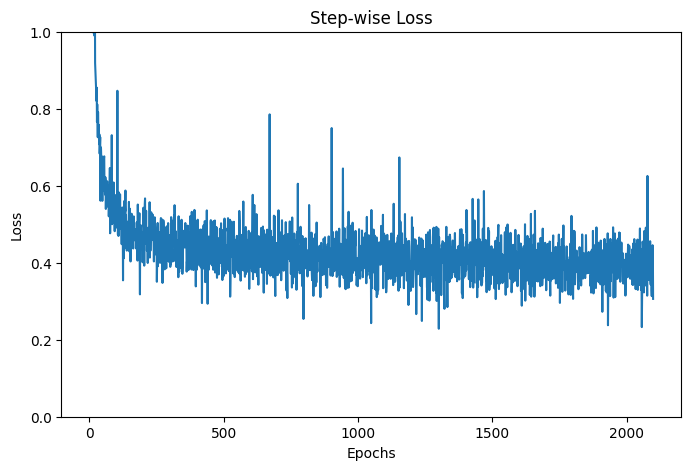

In [11]:
import matplotlib.pyplot as plt

step = range(len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0, 1))
plt.show()

# Evaluate performance on validation data


In [12]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_dataloader:
        outputs = model(features)  # Get model outputs (probabilities from sigmoid)
        
        # Convert probabilities to binary predictions (0 or 1)
        predicted = (outputs >= 0.6).float()
        
        # Calculate accuracy per element (since we have 4 outputs per sample)
        correct += (predicted == labels).sum().item()
        total += labels.numel()  # Total number of elements (batch_size * 4)
        
        # Store for later analysis if needed
        all_predictions.append(predicted.numpy())
        all_labels.append(labels.numpy())

# Calculate overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test set: {accuracy:.2f}%')
print(f'Total predictions: {total} (across {total//4} samples with 4 controls each)')

# Optionally, calculate per-control accuracy
all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)

print("\nPer-control accuracy:")
for i, control in enumerate(['Forward', 'Backward', 'Left', 'Right']):
    control_correct = (all_predictions[:, i] == all_labels[:, i]).sum()
    control_total = len(all_predictions)
    control_accuracy = 100 * control_correct / control_total
    print(f'  {control}: {control_accuracy:.2f}%')

Accuracy of the network on the test set: 80.09%
Total predictions: 648 (across 162 samples with 4 controls each)

Per-control accuracy:
  Forward: 66.05%
  Backward: 94.44%
  Left: 83.33%
  Right: 76.54%


# Save the trained model

In [13]:
# Save the trained model
model_save_path = "slow_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# You can also save with additional info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_loss': loss_values[-1] if loss_values else None,
    'accuracy': accuracy
}
torch.save(checkpoint, "slow_model_checkpoint.pth")
print("Checkpoint saved to slow_model_checkpoint.pth")

Model saved to slow_model.pth
Checkpoint saved to slow_model_checkpoint.pth
